In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=columns)
    df = df.rename(columns=columns)
  return df

## Load the data

In [4]:
filename = "05-table-01-milk-gallons.ods"

df = read_ods(filename)

df


,Week,"Weekly Sales Level, Y (1,000s of gallons)",Selling Price X ($)
0,1,10,1.3
1,2,6,2.0
2,3,5,1.7
3,4,12,1.5
4,5,10,1.6
5,6,15,1.2
6,7,5,1.6
7,8,12,1.4
8,9,17,1.0
9,10,20,1.1


## Compute least squares coefficients ($b_1$ and $b_0$)

$$
\begin{gather*}
  b_1 = \frac{n \sum XY - \sum X \sum Y}{n \sum X^2 - (\sum X)^2} \\[12pt]
  b_0 = \frac{\sum Y}{n} - \frac{b_1 \sum X}{n}
\end{gather*}
$$

In [5]:
df_corr = df.copy()

# rename the corresponding X and Y column
df_corr = df_corr.rename(columns={
  "Weekly Sales Level, Y (1,000s of gallons)": 'Y',
  "Selling Price X ($)": 'X'})

df_corr["XY"] = df_corr['X'] * df_corr['Y']
df_corr["X^2"] = df_corr['X']**2

n = len(df_corr)
sumXY = df_corr["XY"].sum()
sumX = df_corr["X"].sum()
sumY = df_corr["Y"].sum()
sumXsq = df_corr["X^2"].sum()

b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
b0 = sumY/n - b1*sumX/n

print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
df_corr


(b0, b1) = (32.14, -14.54)


,Week,Y,X,XY,X^2
0,1,10,1.3,13.0,1.69
1,2,6,2.0,12.0,4.00
2,3,5,1.7,8.5,2.89
3,4,12,1.5,18.0,2.25
4,5,10,1.6,16.0,2.56
5,6,15,1.2,18.0,1.44
6,7,5,1.6,8.0,2.56
7,8,12,1.4,16.8,1.96
8,9,17,1.0,17.0,1.00
9,10,20,1.1,22.0,1.21


## Point forecast at specific $X$

In [55]:
X_to_forecast = 1.63
hat_Y_point = b0 + b1*X_to_forecast
hat_Y_trueUnit = int(round(hat_Y_point * 1000, -1))
print(f"hat_Y at X=({X_to_forecast:.2f}) : {hat_Y_trueUnit:,d} gallons")

hat_Y at X=(1.63) : 8,440 gallons


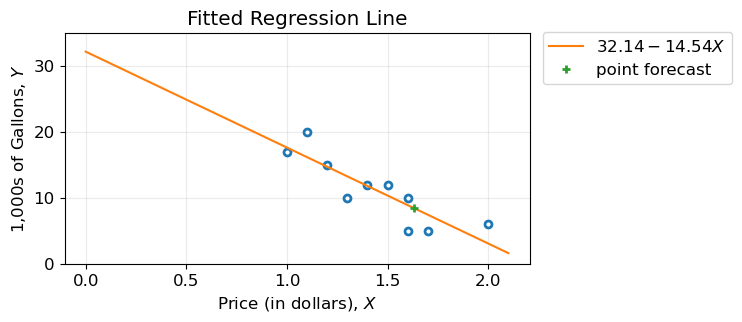

In [58]:
fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_regress = np.linspace(0, 2.1)
ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 

# point forecast
ax.plot([X_to_forecast], [hat_Y_point], 
  marker='+', markersize=6,
  linestyle="None", markeredgewidth=2, 
  label='point forecast')

ax.set_ylim([0, 35])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Standard error of the forecast, $s_f$

$$
  s_f = s_{y\cdot x} \sqrt{
    1 + \frac{1}{n} 
      + \frac{(X - \overline{X})^2}{\sum (X - \overline{X})^2}}
$$

where $s_{y\cdot x}$ is the standard error of the estimate, 

$$
  s_{y \cdot x} = \sqrt{\frac{\sum(Y - \hat{Y})^2}{n - 2}}
$$

A prediction interval for $Y$
$$
\begin{align*}
  &\hat{Y} \pm t\,s_f \quad \textrm{($t$-distribution)}, n < 30 \\
  &\hat{Y} \pm z\,s_f \quad \textrm{(normal distribution)}
\end{align*}
$$

In [111]:
def std_forecast(df, x_regress, reg_coeff):
  # compute std_yx (standard error of the estimate)
  num_of_sample = len(df)

  hat_Y = reg_coeff[0] + reg_coeff[1]*df['X']

  meanX = df['X'].mean() 
  meanY = df['Y'].mean()
  sumOfSquareX_of_meanX = ((df['X'] - meanX)**2).sum()
  sumOfSquareY_of_hat_Y = ((df['Y'] - hat_Y)**2).sum()
  squareX = (x_regress - meanX)**2 

  # print(meanX)
  # print(sumOfSquareX_of_meanX)

  std_yx = np.sqrt(sumOfSquareY_of_hat_Y/(num_of_sample - 2))

  return std_yx * np.sqrt(1 + 1/num_of_sample + squareX/sumOfSquareX_of_meanX)

### Calculate $(\hat{Y} + t\,s_f, \hat{Y} - t\,s_f)$

In [114]:
significance_lvl = 0.05

num_of_sample = len(df)
deg_of_freedom = num_of_sample - 2

# t_score
l_bound = sc_stats.t.ppf(significance_lvl/2, deg_of_freedom)
u_bound = sc_stats.t.ppf(1 - significance_lvl/2, deg_of_freedom)
print(f"t_score (l_bound, u_bound): ({l_bound:.3f}, {u_bound:.3f})")

sf_X = std_forecast(df_corr, x_regress, [b0, b1])
hat_Y = b0 + b1*x_regress
hat_Y_l_bound = hat_Y + l_bound * sf_X 
hat_Y_u_bound = hat_Y + u_bound * sf_X

#hat_Y_l_bound, hat_Y_u_bound

t_score (l_bound, u_bound): (-2.306, 2.306)


### Calculate point foreacast with its interval

In [123]:
sf_single_X = std_forecast(df_corr, X_to_forecast, [b0, b1])
print(f"s_f: {sf_single_X:.2f}")

hat_Y_point_l_bound = hat_Y_point + l_bound*sf_single_X
hat_Y_point_u_bound = hat_Y_point + u_bound*sf_single_X

print(f"(hat_Y - t*sf, hat_Y + t*sf): "+
  f"({hat_Y_point_l_bound:.2f}, {hat_Y_point_u_bound:.2f})")

s_f: 2.91
(hat_Y - t*sf, hat_Y + t*sf): (1.72, 15.16)


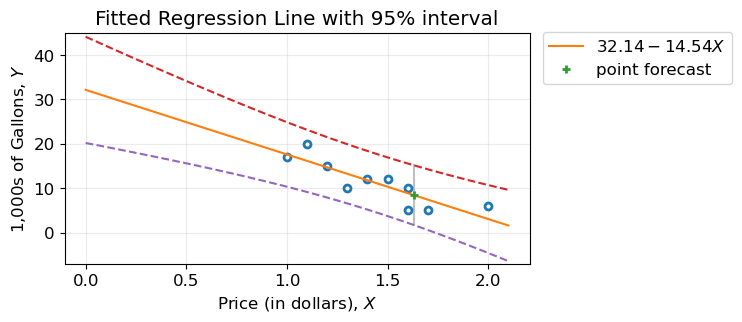

In [126]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_regress = np.linspace(0, 2.1)
ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 

# point forecast
ax.plot([X_to_forecast], [hat_Y_point], 
  marker='+', markersize=6,
  linestyle="None", markeredgewidth=2, 
  label='point forecast')

# plot 95% prediction interval for Y
ax.plot(x_regress, hat_Y_u_bound, linestyle='--',
  marker="None")
ax.plot(x_regress, hat_Y_l_bound, linestyle='--',
  marker="None")

# plot 95% prediction interval for forecast point at X=1.63
ax.plot([X_to_forecast, X_to_forecast],
  [hat_Y_point_l_bound, hat_Y_point_u_bound], 
  color='grey', alpha=0.5, zorder=-99)

ax.set_ylim([-7, 45])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line with 95% interval")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)